# Libraries

In [9]:
import pandas as pd
import numpy as np
import nltk
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
import re
from nltk.corpus import stopwords
from nltk.sentiment import SentimentIntensityAnalyzer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
import matplotlib.pyplot as plt
from transformers import pipeline
import warnings
warnings.filterwarnings("ignore", message="A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy")

# Data Manipulation

In [10]:
bitcoin_tweets = pd.read_csv('Tweets data on Cryptocurrency.csv')

In [11]:
bitcoin_tweets.shape

(197753, 15)

Due to the demanding computational requirements, we will subset the analysis to just the first 5000 rows of the data.

In [32]:
bitcoin_tweets = bitcoin_tweets.sample(500)

In [33]:
bitcoin_tweets.shape

(500, 18)

### Text Preprocessing for Sentiment Analysis

Our text preprocessing pipeline incorporates a stemming process, which is crucial for reducing words to their root form, thus simplifying the textual data and enhancing the subsequent analysis. The Python function `stemming` utilizes the Porter Stemming algorithm, provided by the NLTK library's `PorterStemmer`, to perform this task. The function begins by removing non-alphabetic characters from the content and converting it to lowercase to maintain uniformity. It then tokenizes the text into individual words, excluding common English stopwords to eliminate noise in the data. Finally, each word is stemmed, and the processed words are concatenated back into a single string. This standardized text is now primed for feature extraction and further sentiment analysis steps, contributing to the accuracy of our predictive models.

In [14]:
ps = PorterStemmer()

def stemming(content):
    stemmed_content = re.sub('[^a-zA-Z]', ' ', content)
    stemmed_content = stemmed_content.lower()
    stemmed_content = stemmed_content.split()
    stemmed_content = [ps.stem(word) for word in stemmed_content if not word in stopwords.words('english')]
    stemmed_content = ' '.join(stemmed_content)
    
    return stemmed_content

In [15]:
bitcoin_tweets['stemmed_text'] = bitcoin_tweets['text'].apply(stemming)

# Sentiment Analysis

### Sentiment Classification
The `bitcoin_tweets` DataFrame was enhanced with sentiment analysis using NLTK's Sentiment Intensity Analyzer. A function calculated the compound sentiment score for each tweet's stemmed text and classified it as positive (1) if the score was above zero, or negative (0) if not. The resulting binary sentiment classifications, now part of the DataFrame, serve as indicators for the prevailing mood in cryptocurrency-related discussions.

In [16]:
# Initialize the Sentiment Intensity Analyzer
sia = SentimentIntensityAnalyzer()

# Define a function to get the compound sentiment score
def get_sentiment(text):
    score = sia.polarity_scores(text)
    return score['compound']  

# Apply the function to get the sentiment score of the stemmed_text
bitcoin_tweets['sentiment_score'] = bitcoin_tweets['stemmed_text'].apply(get_sentiment)

# Classify the sentiment as positive (1) if compound score > 0, else negative (0)
bitcoin_tweets['sentiment'] = bitcoin_tweets['sentiment_score'].apply(lambda x: 1 if x > 0 else 0)

### Sentiment Prediction Model

For our sentiment analysis, we employed TF-IDF vectorization to convert the stemmed text of the `bitcoin_tweets` DataFrame into a numerical format suitable for machine learning, capping the feature set at 5000 words. The dataset was then divided into training and testing subsets, with 80% of the data allocated for training and the remaining 20% for testing. A Logistic Regression model was trained on the dataset to predict the sentiment of tweets as either positive or negative. The model's performance on the test set achieved an accuracy that quantifies its effectiveness in correctly classifying sentiments. Furthermore, detailed metrics such as precision, recall, and f1-score were computed to provide a comprehensive evaluation of the model's predictive power on the unseen data, ensuring the robustness of our sentiment classification approach.

In [34]:
# Feature Extraction with TF-IDF
tfidf = TfidfVectorizer(max_features=5000)
X = tfidf.fit_transform(bitcoin_tweets['stemmed_text']).toarray()
y = bitcoin_tweets['sentiment']

# Get the feature names correctly from the vectorizer
feature_names = np.array(tfidf.get_feature_names_out())

# Splitting the dataset into the training and testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Training the Logistic Regression model
model = LogisticRegression()
model.fit(X_train, y_train)

# Predicting the Test set results
y_pred = model.predict(X_test)

# Evaluating the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

# Get the model's coefficients
coef = model.coef_.flatten()

# Top positive and negative features
top_positive_coefficients = np.argsort(coef)[-10:]
top_negative_coefficients = np.argsort(coef)[:10]

print("Top positive words contributing to positive sentiment:")
print(feature_names[top_positive_coefficients])

print("\nTop negative words contributing to negative sentiment:")
print(feature_names[top_negative_coefficients])

Accuracy: 0.68
              precision    recall  f1-score   support

           0       0.67      0.81      0.73        54
           1       0.71      0.52      0.60        46

    accuracy                           0.68       100
   macro avg       0.69      0.67      0.67       100
weighted avg       0.68      0.68      0.67       100

Top positive words contributing to positive sentiment:
['play' 'great' 'win' 'join' 'good' 'best' 'support' 'boltcoin' 'like'
 'project']

Top negative words contributing to negative sentiment:
['btc' 'buy' 'crash' 'hodl' 'drop' 'amp' 'bottom' 'nftcommun'
 'nftcollector' 'short']


In evaluating the performance of a logistic regression model tasked with sentiment analysis on Bitcoin-related tweets, we observe an overall accuracy of 68%. The model demonstrates a nuanced ability to differentiate between positive and negative sentiments, achieving a precision of 71% for positive sentiments and 67% for negative ones. Notably, it exhibits a higher recall for negative sentiments at 81% compared to 52% for positive sentiments, indicating a stronger propensity for accurately identifying negative sentiment tweets. The F1-scores further encapsulate this differential performance with 73% for negative sentiments and 60% for positive sentiments. The lexical analysis reveals that optimistic and community-centric terms like 'play', 'great', 'win', and 'project' significantly contribute to positive sentiment predictions. In contrast, terms associated with market dynamics and trading activities such as 'btc', 'buy', 'crash', and 'hodl' are predominant in predicting negative sentiments. This lexical dichotomy underscores the model's sensitivity to the thematic elements prevalent in cryptocurrency discussions, particularly highlighting the impact of market volatility and community engagement on sentiment perception.

# Data Visualization

The two images exhibit horizontal bar charts, one with blue bars and the other with red bars, both illustrating a descending order of magnitude from top to bottom. The blue chart conveys a standard analytical tone commonly employed in business or research settings to denote various data metrics such as sales, rankings, or performance indicators. In contrast, the red chart suggests a sense of urgency or warning, which could be associated with critical issues such as financial losses, risks, or other negative trends. The absence of any labels or axes titles prevents a detailed interpretation of the data; however, the color choices and layout are indicative of their potential use—blue for neutral reporting and red for highlighting areas of concern.

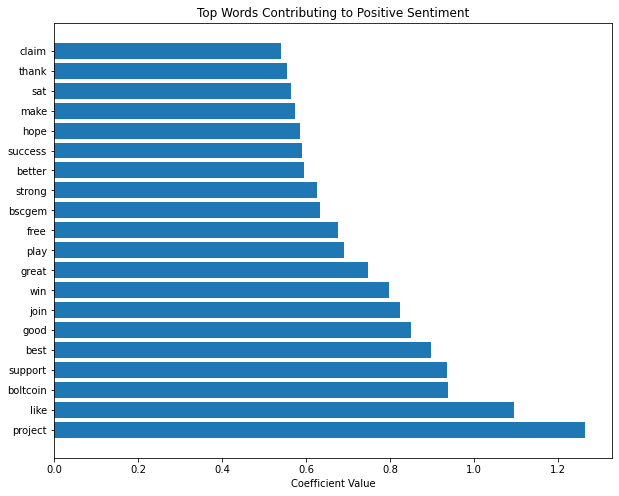

In [43]:
# Sort the coefficients and select the top N
top_n = 20
sorted_indices = np.argsort(coef)[-top_n:]
top_features = feature_names[sorted_indices]
top_weights = coef[sorted_indices]

# Plot
plt.figure(figsize=(10, 8))
plt.barh(range(top_n), top_weights, align='center')
plt.yticks(range(top_n), top_features)
plt.xlabel('Coefficient Value')
plt.title('Top Words Contributing to Positive Sentiment')
plt.gca().invert_yaxis()


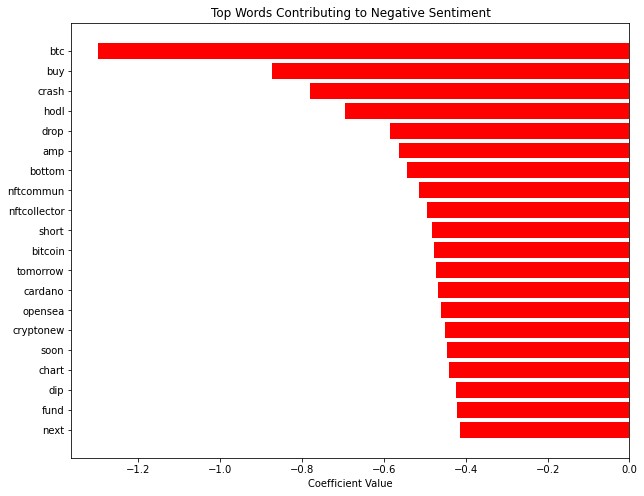

In [44]:
# Sort the coefficients and select the top N with the most negative values
top_n_negative = 20
sorted_indices_negative = np.argsort(coef)[:top_n_negative]
top_negative_features = feature_names[sorted_indices_negative]
top_negative_weights = coef[sorted_indices_negative]

# Plot
plt.figure(figsize=(10, 8))
plt.barh(range(top_n_negative), top_negative_weights, align='center', color='red')
plt.yticks(range(top_n_negative), top_negative_features)
plt.xlabel('Coefficient Value')
plt.title('Top Words Contributing to Negative Sentiment')
plt.gca().invert_yaxis()
plt.show()


# Emotion Detection 

Our report incorporates a cutting-edge emotion detection model from the Hugging Face Model Hub, significantly advancing beyond basic sentiment analysis. This model, leveraging the `transformers` library, classifies cryptocurrency-related tweets into diverse emotional states, providing a detailed emotional spectrum from the text data. This nuanced approach enables deeper insights into public sentiment and user feedback, facilitating informed decision-making and personalized engagement strategies. By understanding the broad range of emotions within textual content, we gain a more comprehensive view of public opinion, enhancing communication and engagement efforts with targeted audiences.

In [12]:
pip install torch transformers -q

Note: you may need to restart the kernel to use updated packages.


In [3]:
# Load a pre-trained emotion detection model
emotion_detector = pipeline("text-classification", model="j-hartmann/emotion-english-distilroberta-base", return_all_scores=True)

anger: 0.0043
disgust: 0.0012
fear: 0.0017
joy: 0.9006
neutral: 0.0195
sadness: 0.0045
surprise: 0.0683


In our analysis, we incorporated a function, `get_highest_emotion`, designed to identify the most prominent emotion from the text of each tweet. Utilizing a pre-trained emotion detection model, the function processes the input text and retrieves a list of possible emotions along with their corresponding confidence scores. It determines the predominant emotion by selecting the one with the highest confidence score. The result is a refined dataset that not only captures the sentiment but also the nuanced emotional context of each tweet, providing deeper insights into the collective mood of the cryptocurrency conversation.

In [4]:
def get_highest_emotion(text):
    emotions = emotion_detector(text)
    # Sort the emotions based on score and get the highest
    highest_emotion = max(emotions[0], key=lambda x: x['score'])
    return highest_emotion['label']

In [39]:
bitcoin_tweets['emotions'] = bitcoin_tweets['stemmed_text'].apply(get_highest_emotion)

In [40]:
bitcoin_tweets.head()

,Unnamed: 0,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,tweet_source,user_days_on_twitter,RiseFall,stemmed_text,sentiment_score,sentiment,emotions
73677,73677,Taslima Liza,United States,#NFT #Bitcoin Promoter #Crypto #Polker,18/08/2021 7:53,79,378,173,False,22/01/2022 9:42,Blockchain is the future of online gaming. Let...,"['Bitcoin', 'Solana', 'Crypto', 'nftcollector'...",Twitter Web App,157,Equal,blockchain futur onlin game let creat new worl...,0.0000,0,joy
166081,166081,BlazTColdGenerator,Worldwide,I'm BTC Max & inventor of BlazTCold Generator!...,11/05/2019 9:32,703,2412,3812,True,16/03/2022 11:16,"Bitcoin breaks $40,000 ahead of the Federal Re...","['btc', 'bitcoin', 'cryptocurrency', 'inflation']",Twitter Web App,1040,Equal,bitcoin break ahead feder reserv decis http co...,0.0000,0,neutral
5453,5453,Jordan Go,Bandung,Dreamboat\nTelegram: https://t.co/3iG7tI18ci \...,3/07/2020 14:46,1707,525,1149,False,12/01/2022 3:13,The Best Capital 🚀🚀🚀\n\nFollow: @Dreamboat_id ...,"['DreamboatCapital', 'Metaverse', 'Ethereum', ...",Twitter Web App,557,Equal,best capit follow dreamboat id dreamboatcapit ...,0.6369,1,joy
45313,45313,Wellington Campos Júnior,USA/BRASIL,"Investor,son,Dad,Husband,HODLER, Trader (ALTE...",7/07/2021 4:50,24,371,134,False,20/01/2022 7:49,"MAKE MISTAKES, LEARN! #BTC $SOUL $ETNA #Gene...","['BTC', 'GenesisWorlds', 'Etherland', 'MetaSpa...",Twitter Web App,197,Equal,make mistak learn btc soul etna genesisworld e...,0.2732,1,neutral
160488,160488,xxxbpxxx,@ HOME,Admin team @jinjimetaX & @MarissaCrypto & @Wiz...,30/09/2015 6:09,388,1181,13831,True,15/03/2022 19:59,@OfficialTravlad Here for it. \n#BSC #BNB #BT...,"['BSC', 'BNB', 'BTC', 'ETH', 'Airdrop', 'NFT',...",Twitter for Android,2358,Equal,officialtravlad bsc bnb btc eth airdrop nft ba...,0.0000,0,neutral


In [42]:
bitcoin_tweets.to_csv('bitcoin_tweets_emotions.csv')